# Initial NLP

In [98]:
import src.nlp as nlp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from pprint import pprint

Let's load the our two datasets.

In [4]:
beer_df = pd.read_csv('data/beers.csv')
reviews_df = pd.read_csv('data/reviews.csv')

In [5]:
print(beer_df.info())
print(reviews_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9248 entries, 0 to 9247
Data columns (total 15 columns):
abv                    8998 non-null float64
beer                   9248 non-null object
beer_url               9248 non-null object
brewery                9248 non-null object
brewery_profile_url    9248 non-null object
gots                   9248 non-null float64
note                   9248 non-null object
pdev                   9248 non-null float64
rank                   8876 non-null float64
rating                 9248 non-null float64
ratings_count          9248 non-null float64
review_count           9248 non-null float64
style                  9248 non-null object
trade                  9248 non-null float64
wants                  9248 non-null float64
dtypes: float64(9), object(6)
memory usage: 1.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790216 entries, 0 to 790215
Data columns (total 9 columns):
author       790216 non-null object
beer         790216 n

Since our datasets are so large, it's going to be a bit tedious to work with all the data at once for this initial pass. So, let's sample 1000 beers. We'll use all of the reviews associated with these beers.

In [6]:
beer_sample = beer_df.sample(1000)

In [9]:
print(beer_sample.info())
print(beer_sample['beer'].describe())
print(beer_sample[beer_sample['beer']=='stout'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 219 to 5585
Data columns (total 15 columns):
abv                    969 non-null float64
beer                   1000 non-null object
beer_url               1000 non-null object
brewery                1000 non-null object
brewery_profile_url    1000 non-null object
gots                   1000 non-null float64
note                   1000 non-null object
pdev                   1000 non-null float64
rank                   965 non-null float64
rating                 1000 non-null float64
ratings_count          1000 non-null float64
review_count           1000 non-null float64
style                  1000 non-null object
trade                  1000 non-null float64
wants                  1000 non-null float64
dtypes: float64(9), object(6)
memory usage: 125.0+ KB
None
count      1000
unique      998
top       stout
freq          2
Name: beer, dtype: object
      abv   beer                                           beer_url  \
5238

As you can see, we have two beers with the same name. Fortunately, they are differentiated by brewery.

Let's generate the review_id's associated with our beer sample. We can use these id's to get to the correct reviews.

In [16]:
beer_sample['review_id'] = beer_sample['brewery'] + ' ' + beer_sample['beer']
reviews_df = nlp.get_brew_beer_col(reviews_df)

reviews_sample = reviews_df[reviews_df['brew_beer'].isin(beer_sample['review_id'].unique())]

In [21]:
reviews_sample.head()

,author,beer,feel,look,overall,review_id,smell,taste,text,brew_beer,review_num
4,/community/members/biboergosum.168458/,death or glory,4.00,4.00,4.00,tring brewery company ltd. death or glory 4,4.00,4.00,4/5 rDev +3.1%look: 4 | smell: 4 | taste: 4 |...,tring brewery company ltd. death or glory,4
9,/community/members/gonzo46and2.185769/,maduro oatmeal brown ale - vanilla,4.50,4.00,4.50,cigar city brewing maduro oatmeal brown ale - ...,4.50,5.00,4.67/5 rDev +14.2%look: 4 | smell: 4.5 | tast...,cigar city brewing maduro oatmeal brown ale - ...,67
12,/community/members/trueperception.751390/,organic strawberry,3.75,3.75,3.75,samuel smith old brewery (tadcaster) organic s...,4.25,3.75,3.87/5 rDev +1.3%look: 3.75 | smell: 4.25 | t...,samuel smith old brewery (tadcaster) organic s...,29
32,/community/members/captaintripps.489114/,pannepot reserva,4.00,4.00,4.50,de struise brouwers pannepot reserva 244,4.50,4.50,4.42/5 rDev +2.8%look: 4 | smell: 4.5 | taste...,de struise brouwers pannepot reserva,244
35,/community/members/seedee17.6250/,steam engine lager,3.50,3.50,4.00,steamworks brewing co. steam engine lager 89,3.00,3.00,3.28/5 rDev -3.2%look: 3.5 | smell: 3 | taste...,steamworks brewing co. steam engine lager,89


In [22]:
print(reviews_sample.info())
print(reviews_sample['beer'].describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71529 entries, 4 to 790210
Data columns (total 11 columns):
author        71529 non-null object
beer          71529 non-null object
feel          70728 non-null float64
look          70728 non-null float64
overall       70728 non-null float64
review_id     71529 non-null object
smell         70728 non-null float64
taste         70728 non-null float64
text          71529 non-null object
brew_beer     71529 non-null object
review_num    71529 non-null int64
dtypes: float64(5), int64(1), object(5)
memory usage: 6.5+ MB
None
count               71529
unique                998
top       two hearted ale
freq                 3734
Name: beer, dtype: object


Let's reindex both of our sample dataframes. This will be useful later when we need to interpet the results of SVD and NMF. We'll keep the current index as a column. This might be useful if we need to reference the index of the full dataframe for some reason.

In [25]:
beer_sample.reset_index(inplace=True)
reviews_sample.reset_index(inplace=True)

## Document Cleaning

In [78]:
documents = reviews_sample['text'].values
documents = nlp.clean_documents(documents)

Let's go ahead and remove the punctation and stopwords from our documents.

In [79]:
documents = nlp.strip_punc(documents)

In [80]:
documents[0]

'330ml bottle  best before feb 2012  cool rah-rah  britannia  machismo-laced label   this beer pour a perfectly clear dark amber hue  with one skinny finger of tight foamy off-white head  which leaves very little in the way of lace as it quickly recedes  it smells of strong toffee notes  a bit of caramel nougat  and a nice warming booziness  the taste is sweet caramel toffee treacle oriented malt  a little nutty breadiness  and a lovely seen but not heard kind of alcohol warmth  the carbonation is very innocuous  i e  nearing flatness  the body a hefty medium weight  kind of sugary  but that s a-ok for qualifying as smooth  it finishes sweet  christmas cakes and cookies  and prezzies by the hearth and all that   an enjoyable strong ale  on the malt up yer arse side  but still  nice concept  well rendered execution  and appreciation from those of us out of cask range '

And, now we can stem these words.

In [81]:
documents = nlp.stem_and_rem_stopwords(documents)

In [82]:
documents[0]

'330ml bottle best feb 2012 cool rah-rah britannia machismo-laced label beer pour perfectly clear dark amber hue one skinny finger tight foamy off-white head leaves little way lace quickly recedes smells strong toffee notes bit caramel nougat nice warming booziness taste sweet caramel toffee treacle oriented malt little nutty breadiness lovely seen heard kind alcohol warmth carbonation innocuous e nearing flatness body hefty medium weight kind sugary a-ok qualifying smooth finishes sweet christmas cakes cookies prezzies hearth enjoyable strong ale malt yer arse side still nice concept well rendered execution appreciation us cask range'

And now let's feed these documents into our tf-idf vectorizer.

In [84]:
tf_idf_vec = TfidfVectorizer()

In [85]:
doc_term = tf_idf_vec.fit_transform(documents)

In [89]:
doc_term.shape

(71529, 55498)

## SVD

With our tf-idf matrix in place, we can now perform SVD on our data. We can then use this data to make an informed decision regarding the number of features to extract.

In [92]:
svd = TruncatedSVD(n_components=100)

In [93]:
results = svd.fit_transform(doc_term)

In [96]:
results.shape

(71529, 100)

In [97]:
svd.explained_variance_ratio_

array([0.00419039, 0.00824071, 0.00576622, 0.00497496, 0.00427084,
       0.0039473 , 0.00365079, 0.00330043, 0.00313077, 0.00278431,
       0.00273174, 0.00254123, 0.00247913, 0.00237791, 0.00233153,
       0.0022678 , 0.00223875, 0.00218901, 0.00210772, 0.00207355,
       0.00203274, 0.00201477, 0.00196837, 0.00193752, 0.00189814,
       0.00188055, 0.00186527, 0.00183013, 0.00181884, 0.00178658,
       0.00176597, 0.00171488, 0.00170197, 0.00168968, 0.00167642,
       0.00164881, 0.0016252 , 0.00160482, 0.00159668, 0.00157872,
       0.00155344, 0.00154814, 0.00153666, 0.00152988, 0.001525  ,
       0.00148403, 0.00148371, 0.00146271, 0.0014536 , 0.00143011,
       0.00141832, 0.00139558, 0.00139473, 0.00137844, 0.0013693 ,
       0.00134675, 0.00134472, 0.00133362, 0.00132972, 0.00131984,
       0.00131328, 0.00130163, 0.00129509, 0.00128873, 0.00127623,
       0.00126695, 0.00125882, 0.00124903, 0.00123551, 0.0012297 ,
       0.00122141, 0.00121031, 0.00120009, 0.00119529, 0.00118

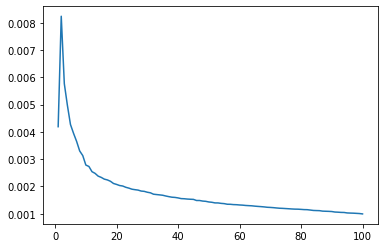

In [105]:
ax = plt.subplot()
ax.plot(range(1, len(svd.explained_variance_ratio_)+1), svd.explained_variance_ratio_)

In [100]:
svd.explained_variance_

array([0.00400484, 0.00787582, 0.00551089, 0.00475468, 0.00408173,
       0.00377252, 0.00348914, 0.00315429, 0.00299214, 0.00266102,
       0.00261078, 0.00242871, 0.00236936, 0.00227262, 0.00222829,
       0.00216738, 0.00213962, 0.00209208, 0.00201439, 0.00198174,
       0.00194273, 0.00192556, 0.00188121, 0.00185173, 0.0018141 ,
       0.00179729, 0.00178268, 0.00174909, 0.0017383 , 0.00170747,
       0.00168778, 0.00163895, 0.00162661, 0.00161486, 0.00160219,
       0.0015758 , 0.00155324, 0.00153376, 0.00152598, 0.00150882,
       0.00148465, 0.00147959, 0.00146862, 0.00146214, 0.00145747,
       0.00141832, 0.00141801, 0.00139794, 0.00138924, 0.00136679,
       0.00135552, 0.00133379, 0.00133298, 0.0013174 , 0.00130867,
       0.00128712, 0.00128517, 0.00127457, 0.00127084, 0.0012614 ,
       0.00125513, 0.00124399, 0.00123774, 0.00123166, 0.00121972,
       0.00121085, 0.00120308, 0.00119372, 0.0011808 , 0.00117525,
       0.00116732, 0.00115672, 0.00114695, 0.00114236, 0.00113